# Body Weight Predicition Using a LSTM Neural Network 

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem. (http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# from base_etl import BaseETL
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
start_of_predicition=30
dependend_variable_period=35
file_path = 'data/bw_ross_308.csv'


## Extraction

initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).


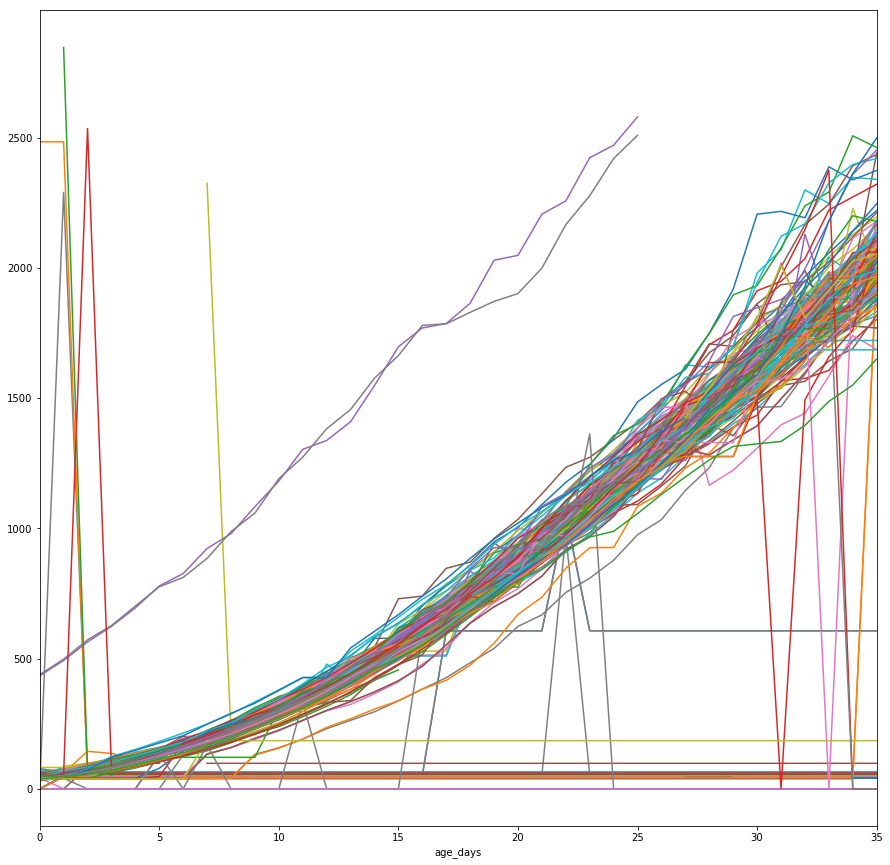

In [5]:
df_raw = pd.read_csv(file_path).sort_values('age_days').reset_index(drop=True)

print('initial shape df : {}'.format(df_raw.shape))

# remove empty columns
df_raw = df_raw.dropna(axis=1, how='all')

print('removed rounds with empty body weight. shape of df {}'.format(df_raw.shape))
    
# we can have only 1 value per day for bw.
df_raw = df_raw.drop_duplicates(subset='age_days')

print('removed duplicates days. we can only have 1 value per day. '
      'we keep the first value we encounter. shape of df {}'.format(df_raw.shape))

# remove data after 35 days
df_raw = df_raw[df_raw['age_days'] <= dependend_variable_period]
df_raw = df_raw.set_index('age_days', drop=True)

print('removed values for days after our dependend variable {} '
      '- shape of df {}.'.format(dependend_variable_period, df_raw.shape))

df_raw.plot(legend=False, figsize=(15,15))
plt.show()


## Cleansing

After the extraction we see a lot of dirty data. constants, unrealistic values in the beginning and the end of the round, missing values for our dependend variable. we are now going to remove these dirty records so that we have clean data to start training.

we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


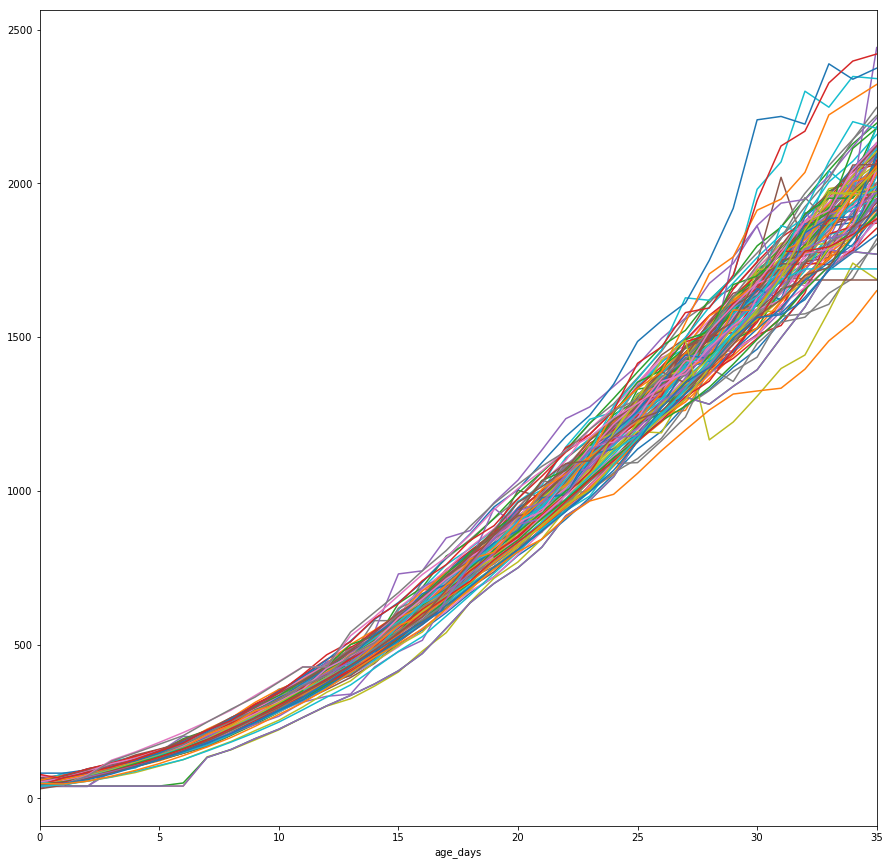

In [6]:
# remove rounds with no initial data
mask_no_initial_data = df_raw.fillna(method='ffill').notnull()
df_raw = df_raw.loc[:, mask_no_initial_data.all(axis=0)]

print('we cannot use rounds with no initial data. shape of df {}'.format(df_raw.shape))

# remove rounds which have NaN before 35 days
mask_no_end_data = df_raw.fillna(method='backfill').notnull()
df_raw = df_raw.loc[:, mask_no_end_data.all(axis=0)]

print('we remove rounds which have no data before our dependend variable. shape of df is {}'.format(dependend_variable_period, df_raw.shape))

# remove all columns that have same value
df_raw = df_raw.loc[:, df_raw.all(axis=0)]

print('we remove all columns with the same value'.format(df_raw.shape))

def duplicate_values_in_series(df, percentage_same_values=0.25):
    '''
    remove columns that have the same value for more than the percentage_same_values.
    if a column satisfies this condition we remove it.

    if we have a record with e.g. number of values equal to 4 that is more than percentage_same_value,
    we do not want this in out training/testing set.

    :param df:
    :param percentage_same_values:
    :return:
    '''
    for column in df:
        duplicates_mask = df[column].value_counts()
        _len = float(len(duplicates_mask))
        duplicates = duplicates_mask.max()
        if duplicates / _len >= percentage_same_values:
            del df[column]
    return df

df_raw = duplicate_values_in_series(df_raw)

print('we remove series with 25% same values in the series. df shape is {}'.format(df_raw.shape))

# drop columns which have extreme values in the beginning of the round.
# sometimes the regulator is not reset before the next flock starts.
# we ignore these extreme values
# we keep the columns which have no extreme values in the first 5 days.

df_raw = df_raw.loc[:, ~((df_raw.iloc[:5, :] > 500).any())]

print('drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is {}'.format(df_raw.shape))

df = df_raw.copy()
df.plot(legend=False, figsize=(15,15))
plt.show()

## Defining the lookback period to predict day 35 when we have data until day 30

how many days do we have to take into account to find the best match to predict the bodyweight on day 35 staring from day 30? we will now iteratively predict day 35 from day 30 using x number of days before day 30. we will first start with only day 29 as input for our prediction, calculate the root mean squared error. Then we will use day 29 and 28 as input for our prediction, calculate the root mean squared error. we continue like this until we use all 30 days as input for our prediction.


In [8]:
from long_short_term_memory_network_predictor import find_best_look_back_period
best_score = find_best_look_back_period(df, neurons = 4)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1587
Epoch 2/10
0s - loss: 0.0738
Epoch 3/10
0s - loss: 0.0318
Epoch 4/10
0s - loss: 0.0190
Epoch 5/10
0s - loss: 0.0169
Epoch 6/10
0s - loss: 0.0165
Epoch 7/10
0s - loss: 0.0162
Epoch 8/10
0s - loss: 0.0160
Epoch 9/10
0s - loss: 0.0157
Epoch 10/10
0s - loss: 0.0152
Train Score: 96.40 RMSE
Test Score: 129.51 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1752
Epoch 2/10
0s - loss: 0.0728
Epoch 3/10
0s - loss: 0.0268
Epoch 4/10
0s - loss: 0.0169
Epoch 5/10
0s - loss: 0.0159
Epoch 6/10
0s - loss: 0.0156
Epoch 7/10
0s - loss: 0.0154
Epoch 8/10
0s - loss: 0.0152
Epoch 9/10
0s - loss: 0.0149
Epoch 10/10
0s - loss: 0.0145
Train Score: 94.21 RMSE
Test Score: 110.02 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
17s - loss: 0.2107
Epoch 2/10
2s - loss: 0.0953
Epoch 3/10
1s - loss: 0.0299
Epoch 4/10
1s - loss: 0.0171
Epoch 5/10
1s - loss: 0.0163
Epoch 6/10
1s - loss: 0.0160
Epoch 7/10
1s - loss: 0.0158
Epoch 8/10
1s - loss: 0.0155
Epoch 9/10
1s - loss: 0.0152
Epoch 10/10
1s - loss: 0.0148
Train Score: 95.02 RMSE
Test Score: 97.66 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1745
Epoch 2/10
0s - loss: 0.0625
Epoch 3/10
0s - loss: 0.0185
Epoch 4/10
0s - loss: 0.0135
Epoch 5/10
0s - loss: 0.0132
Epoch 6/10
0s - loss: 0.0129
Epoch 7/10
0s - loss: 0.0127
Epoch 8/10
0s - loss: 0.0125
Epoch 9/10
0s - loss: 0.0122
Epoch 10/10
0s - loss: 0.0120
Train Score: 85.21 RMSE
Test Score: 91.17 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1319
Epoch 2/10
0s - loss: 0.0363
Epoch 3/10
0s - loss: 0.0134
Epoch 4/10
0s - loss: 0.0120
Epoch 5/10
0s - loss: 0.0117
Epoch 6/10
0s - loss: 0.0115
Epoch 7/10
0s - loss: 0.0114
Epoch 8/10
0s - loss: 0.0112
Epoch 9/10
0s - loss: 0.0110
Epoch 10/10
0s - loss: 0.0108
Train Score: 81.02 RMSE
Test Score: 85.03 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1283
Epoch 2/10
0s - loss: 0.0338
Epoch 3/10
0s - loss: 0.0139
Epoch 4/10
0s - loss: 0.0129
Epoch 5/10
0s - loss: 0.0127
Epoch 6/10
0s - loss: 0.0125
Epoch 7/10
0s - loss: 0.0124
Epoch 8/10
0s - loss: 0.0122
Epoch 9/10
0s - loss: 0.0120
Epoch 10/10
0s - loss: 0.0119
Train Score: 84.90 RMSE
Test Score: 83.75 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1282
Epoch 2/10
0s - loss: 0.0304
Epoch 3/10
0s - loss: 0.0129
Epoch 4/10
0s - loss: 0.0125
Epoch 5/10
0s - loss: 0.0124
Epoch 6/10
0s - loss: 0.0123
Epoch 7/10
0s - loss: 0.0124
Epoch 8/10
0s - loss: 0.0122
Epoch 9/10
0s - loss: 0.0121
Epoch 10/10
0s - loss: 0.0121
Train Score: 85.68 RMSE
Test Score: 87.38 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.1057
Epoch 2/10
0s - loss: 0.0178
Epoch 3/10
0s - loss: 0.0113
Epoch 4/10
0s - loss: 0.0112
Epoch 5/10
0s - loss: 0.0112
Epoch 6/10
0s - loss: 0.0110
Epoch 7/10
0s - loss: 0.0112
Epoch 8/10
0s - loss: 0.0110
Epoch 9/10
0s - loss: 0.0109
Epoch 10/10
0s - loss: 0.0110
Train Score: 81.19 RMSE
Test Score: 81.22 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.0953
Epoch 2/10
0s - loss: 0.0145
Epoch 3/10
0s - loss: 0.0120
Epoch 4/10
0s - loss: 0.0119
Epoch 5/10
0s - loss: 0.0118
Epoch 6/10
0s - loss: 0.0117
Epoch 7/10
0s - loss: 0.0119
Epoch 8/10
0s - loss: 0.0116
Epoch 9/10
0s - loss: 0.0115
Epoch 10/10
0s - loss: 0.0116
Train Score: 83.24 RMSE
Test Score: 75.75 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
1s - loss: 0.0727
Epoch 2/10
0s - loss: 0.0133
Epoch 3/10
0s - loss: 0.0121
Epoch 4/10
0s - loss: 0.0120
Epoch 5/10
0s - loss: 0.0120
Epoch 6/10
0s - loss: 0.0118
Epoch 7/10
0s - loss: 0.0121
Epoch 8/10
0s - loss: 0.0118
Epoch 9/10
0s - loss: 0.0117
Epoch 10/10
0s - loss: 0.0118
Train Score: 84.11 RMSE
Test Score: 81.88 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.1244
Epoch 2/10
0s - loss: 0.0177
Epoch 3/10
0s - loss: 0.0140
Epoch 4/10
0s - loss: 0.0136
Epoch 5/10
0s - loss: 0.0134
Epoch 6/10
0s - loss: 0.0132
Epoch 7/10
0s - loss: 0.0134
Epoch 8/10
0s - loss: 0.0129
Epoch 9/10
0s - loss: 0.0128
Epoch 10/10
0s - loss: 0.0128
Train Score: 87.57 RMSE
Test Score: 94.73 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0930
Epoch 2/10
0s - loss: 0.0137
Epoch 3/10
0s - loss: 0.0124
Epoch 4/10
0s - loss: 0.0121
Epoch 5/10
0s - loss: 0.0119
Epoch 6/10
0s - loss: 0.0117
Epoch 7/10
0s - loss: 0.0120
Epoch 8/10
0s - loss: 0.0116
Epoch 9/10
0s - loss: 0.0114
Epoch 10/10
0s - loss: 0.0116
Train Score: 82.89 RMSE
Test Score: 88.62 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0818
Epoch 2/10
0s - loss: 0.0133
Epoch 3/10
0s - loss: 0.0126
Epoch 4/10
0s - loss: 0.0124
Epoch 5/10
0s - loss: 0.0123
Epoch 6/10
0s - loss: 0.0122
Epoch 7/10
0s - loss: 0.0124
Epoch 8/10
0s - loss: 0.0120
Epoch 9/10
0s - loss: 0.0118
Epoch 10/10
0s - loss: 0.0120
Train Score: 84.33 RMSE
Test Score: 97.04 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0507
Epoch 2/10
0s - loss: 0.0112
Epoch 3/10
0s - loss: 0.0112
Epoch 4/10
0s - loss: 0.0109
Epoch 5/10
0s - loss: 0.0109
Epoch 6/10
0s - loss: 0.0108
Epoch 7/10
0s - loss: 0.0111
Epoch 8/10
0s - loss: 0.0107
Epoch 9/10
0s - loss: 0.0105
Epoch 10/10
0s - loss: 0.0108
Train Score: 79.74 RMSE
Test Score: 91.18 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0718
Epoch 2/10
0s - loss: 0.0136
Epoch 3/10
0s - loss: 0.0130
Epoch 4/10
0s - loss: 0.0127
Epoch 5/10
0s - loss: 0.0125
Epoch 6/10
0s - loss: 0.0124
Epoch 7/10
0s - loss: 0.0126
Epoch 8/10
0s - loss: 0.0121
Epoch 9/10
0s - loss: 0.0120
Epoch 10/10
0s - loss: 0.0122
Train Score: 84.93 RMSE
Test Score: 98.60 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0582
Epoch 2/10
0s - loss: 0.0122
Epoch 3/10
0s - loss: 0.0120
Epoch 4/10
0s - loss: 0.0117
Epoch 5/10
0s - loss: 0.0116
Epoch 6/10
0s - loss: 0.0115
Epoch 7/10
0s - loss: 0.0118
Epoch 8/10
0s - loss: 0.0113
Epoch 9/10
0s - loss: 0.0112
Epoch 10/10
0s - loss: 0.0114
Train Score: 82.02 RMSE
Test Score: 96.80 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0528
Epoch 2/10
0s - loss: 0.0123
Epoch 3/10
0s - loss: 0.0122
Epoch 4/10
0s - loss: 0.0118
Epoch 5/10
0s - loss: 0.0118
Epoch 6/10
0s - loss: 0.0117
Epoch 7/10
0s - loss: 0.0120
Epoch 8/10
0s - loss: 0.0114
Epoch 9/10
0s - loss: 0.0113
Epoch 10/10
0s - loss: 0.0116
Train Score: 82.59 RMSE
Test Score: 99.74 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0479
Epoch 2/10
0s - loss: 0.0130
Epoch 3/10
0s - loss: 0.0131
Epoch 4/10
0s - loss: 0.0126
Epoch 5/10
0s - loss: 0.0125
Epoch 6/10
0s - loss: 0.0124
Epoch 7/10
0s - loss: 0.0127
Epoch 8/10
0s - loss: 0.0121
Epoch 9/10
0s - loss: 0.0118
Epoch 10/10
0s - loss: 0.0120
Train Score: 84.10 RMSE
Test Score: 101.43 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0811
Epoch 2/10
0s - loss: 0.0152
Epoch 3/10
0s - loss: 0.0148
Epoch 4/10
0s - loss: 0.0143
Epoch 5/10
0s - loss: 0.0142
Epoch 6/10
0s - loss: 0.0139
Epoch 7/10
0s - loss: 0.0142
Epoch 8/10
0s - loss: 0.0135
Epoch 9/10
0s - loss: 0.0134
Epoch 10/10
0s - loss: 0.0135
Train Score: 89.30 RMSE
Test Score: 110.94 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0794
Epoch 2/10
0s - loss: 0.0136
Epoch 3/10
0s - loss: 0.0132
Epoch 4/10
0s - loss: 0.0127
Epoch 5/10
0s - loss: 0.0127
Epoch 6/10
0s - loss: 0.0124
Epoch 7/10
0s - loss: 0.0126
Epoch 8/10
0s - loss: 0.0120
Epoch 9/10
0s - loss: 0.0119
Epoch 10/10
0s - loss: 0.0120
Train Score: 84.17 RMSE
Test Score: 108.81 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0748
Epoch 2/10
0s - loss: 0.0150
Epoch 3/10
0s - loss: 0.0147
Epoch 4/10
0s - loss: 0.0140
Epoch 5/10
0s - loss: 0.0140
Epoch 6/10
0s - loss: 0.0135
Epoch 7/10
0s - loss: 0.0136
Epoch 8/10
0s - loss: 0.0128
Epoch 9/10
0s - loss: 0.0126
Epoch 10/10
0s - loss: 0.0127
Train Score: 86.08 RMSE
Test Score: 105.38 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0677
Epoch 2/10
0s - loss: 0.0151
Epoch 3/10
0s - loss: 0.0149
Epoch 4/10
0s - loss: 0.0140
Epoch 5/10
0s - loss: 0.0140
Epoch 6/10
0s - loss: 0.0135
Epoch 7/10
0s - loss: 0.0136
Epoch 8/10
0s - loss: 0.0127
Epoch 9/10
0s - loss: 0.0125
Epoch 10/10
0s - loss: 0.0126
Train Score: 86.00 RMSE
Test Score: 107.68 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.0722
Epoch 2/10
0s - loss: 0.0165
Epoch 3/10
0s - loss: 0.0160
Epoch 4/10
0s - loss: 0.0149
Epoch 5/10
0s - loss: 0.0146
Epoch 6/10
0s - loss: 0.0140
Epoch 7/10
0s - loss: 0.0139
Epoch 8/10
0s - loss: 0.0129
Epoch 9/10
0s - loss: 0.0125
Epoch 10/10
0s - loss: 0.0126
Train Score: 85.51 RMSE
Test Score: 104.72 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0689
Epoch 2/10
0s - loss: 0.0157
Epoch 3/10
0s - loss: 0.0152
Epoch 4/10
0s - loss: 0.0141
Epoch 5/10
0s - loss: 0.0139
Epoch 6/10
0s - loss: 0.0133
Epoch 7/10
0s - loss: 0.0131
Epoch 8/10
0s - loss: 0.0122
Epoch 9/10
0s - loss: 0.0117
Epoch 10/10
0s - loss: 0.0119
Train Score: 83.19 RMSE
Test Score: 105.45 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0529
Epoch 2/10
0s - loss: 0.0164
Epoch 3/10
0s - loss: 0.0159
Epoch 4/10
0s - loss: 0.0145
Epoch 5/10
0s - loss: 0.0142
Epoch 6/10
0s - loss: 0.0134
Epoch 7/10
0s - loss: 0.0133
Epoch 8/10
0s - loss: 0.0121
Epoch 9/10
0s - loss: 0.0116
Epoch 10/10
0s - loss: 0.0120
Train Score: 82.77 RMSE
Test Score: 100.65 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0570
Epoch 2/10
0s - loss: 0.0169
Epoch 3/10
0s - loss: 0.0161
Epoch 4/10
0s - loss: 0.0147
Epoch 5/10
0s - loss: 0.0141
Epoch 6/10
0s - loss: 0.0133
Epoch 7/10
0s - loss: 0.0130
Epoch 8/10
0s - loss: 0.0119
Epoch 9/10
0s - loss: 0.0114
Epoch 10/10
0s - loss: 0.0114
Train Score: 81.47 RMSE
Test Score: 101.90 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0572
Epoch 2/10
0s - loss: 0.0181
Epoch 3/10
0s - loss: 0.0174
Epoch 4/10
0s - loss: 0.0160
Epoch 5/10
0s - loss: 0.0156
Epoch 6/10
0s - loss: 0.0148
Epoch 7/10
0s - loss: 0.0146
Epoch 8/10
0s - loss: 0.0134
Epoch 9/10
0s - loss: 0.0130
Epoch 10/10
0s - loss: 0.0134
Train Score: 87.58 RMSE
Test Score: 105.94 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.0654
Epoch 2/10
0s - loss: 0.0182
Epoch 3/10
0s - loss: 0.0172
Epoch 4/10
0s - loss: 0.0157
Epoch 5/10
0s - loss: 0.0153
Epoch 6/10
0s - loss: 0.0144
Epoch 7/10
0s - loss: 0.0140
Epoch 8/10
0s - loss: 0.0129
Epoch 9/10
0s - loss: 0.0123
Epoch 10/10
0s - loss: 0.0126
Train Score: 85.04 RMSE
Test Score: 106.28 RMSE


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.0577
Epoch 2/10
0s - loss: 0.0187
Epoch 3/10
0s - loss: 0.0178
Epoch 4/10
0s - loss: 0.0162
Epoch 5/10
0s - loss: 0.0158
Epoch 6/10
0s - loss: 0.0149
Epoch 7/10
0s - loss: 0.0145
Epoch 8/10
0s - loss: 0.0134
Epoch 9/10
0s - loss: 0.0130
Epoch 10/10
0s - loss: 0.0133
Train Score: 87.21 RMSE
Test Score: 108.24 RMSE


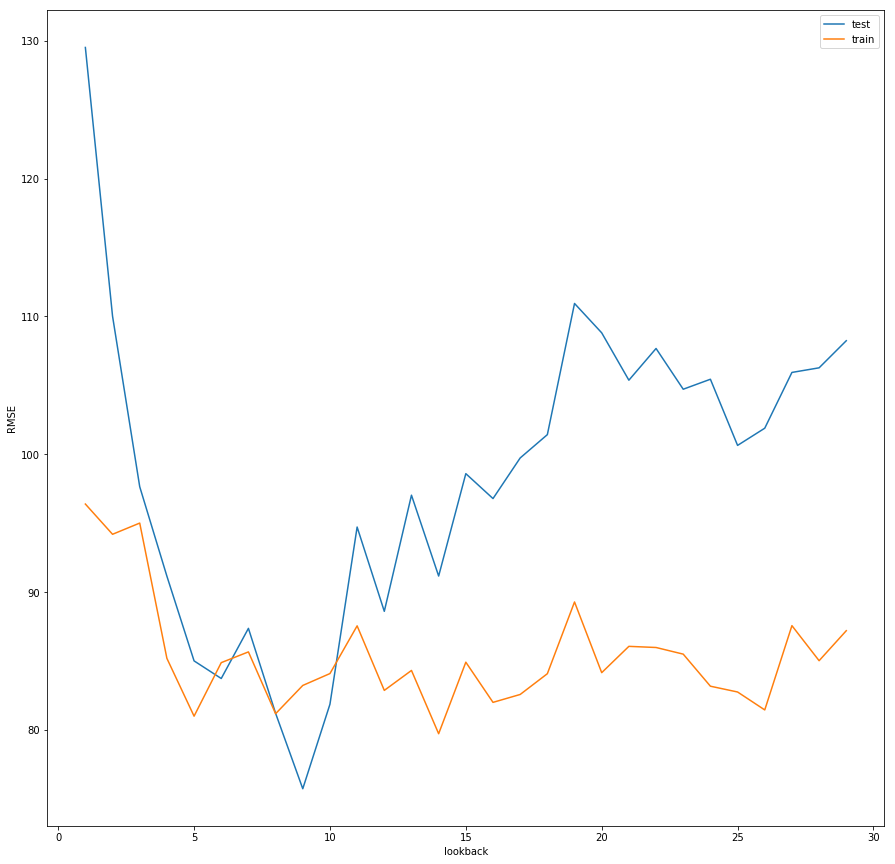

best test score 75.75463010355551 RMSE with train score 83.24443507621183, the lookback period we use starting from day 30 is 9 days


In [10]:
from long_short_term_memory_network_predictor import plot_best_score
plot_best_score(best_score, start_of_predicition)

The average error on the predicted value is 75.75 g if we use 9 days as lookback to predict day 35 when we are at day 30.
how is this average error compared to the standard deviation on the weight of day 35? 
we describe the data we have for day 35:

In [11]:
df.ix[df.index[-1]].describe()

count     112.000000
mean     2021.419643
std       138.123371
min      1651.000000
25%      1946.500000
50%      2032.500000
75%      2092.250000
max      2442.000000
Name: 35.0, dtype: float64

The standarddeviation is 138 g for day 35. Our mean squared error 75.75 is 55% of the standard deviation. So our model has some informative value.

## Predicting the body weight of day 35 for each day of our production round.

For now we assume that 9 days as lookback is the best for the calculation of all days. for all days below 9 we use the n-1 number of days for our calculations.

In [ ]:
from long_short_term_memory_network_predictor import predict_value_using_a_lookback_period

score = predict_value_using_a_lookback_period(9, 30, 35)

initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
4s - loss: 0.1905
Epoch 2/10
0s - loss: 0.0807
Epoch 3/10
0s - loss: 0.0396
Epoch 4/10
0s - loss: 0.0282
Epoch 5/10
0s - loss: 0.0259
Epoch 6/10
0s - loss: 0.0255
Epoch 7/10
0s - loss: 0.0255
Epoch 8/10
0s - loss: 0.0254
Epoch 9/10
0s - loss: 0.0254
Epoch 10/10
0s - loss: 0.0251
Train Score: 124.64 RMSE
Test Score: 177.46 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.1892
Epoch 2/10
0s - loss: 0.0730
Epoch 3/10
0s - loss: 0.0342
Epoch 4/10
0s - loss: 0.0253
Epoch 5/10
0s - loss: 0.0240
Epoch 6/10
0s - loss: 0.0237
Epoch 7/10
0s - loss: 0.0237
Epoch 8/10
0s - loss: 0.0237
Epoch 9/10
0s - loss: 0.0236
Epoch 10/10
0s - loss: 0.0233
Train Score: 120.11 RMSE
Test Score: 174.53 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2229
Epoch 2/10
0s - loss: 0.0859
Epoch 3/10
0s - loss: 0.0375
Epoch 4/10
0s - loss: 0.0261
Epoch 5/10
0s - loss: 0.0244
Epoch 6/10
0s - loss: 0.0241
Epoch 7/10
0s - loss: 0.0240
Epoch 8/10
0s - loss: 0.0240
Epoch 9/10
0s - loss: 0.0239
Epoch 10/10
0s - loss: 0.0235
Train Score: 120.59 RMSE
Test Score: 174.75 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
2s - loss: 0.2395
Epoch 2/10
0s - loss: 0.0872
Epoch 3/10
0s - loss: 0.0358
Epoch 4/10
0s - loss: 0.0252
Epoch 5/10
0s - loss: 0.0238
Epoch 6/10
0s - loss: 0.0236
Epoch 7/10
0s - loss: 0.0235
Epoch 8/10
0s - loss: 0.0235
Epoch 9/10
0s - loss: 0.0233
Epoch 10/10
0s - loss: 0.0230
Train Score: 119.15 RMSE
Test Score: 173.39 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2076
Epoch 2/10
0s - loss: 0.0674
Epoch 3/10
0s - loss: 0.0290
Epoch 4/10
0s - loss: 0.0233
Epoch 5/10
0s - loss: 0.0228
Epoch 6/10
0s - loss: 0.0226
Epoch 7/10
0s - loss: 0.0226
Epoch 8/10
0s - loss: 0.0226
Epoch 9/10
0s - loss: 0.0225
Epoch 10/10
0s - loss: 0.0221
Train Score: 116.79 RMSE
Test Score: 169.44 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1749
Epoch 2/10
0s - loss: 0.0511
Epoch 3/10
0s - loss: 0.0251
Epoch 4/10
0s - loss: 0.0225
Epoch 5/10
0s - loss: 0.0223
Epoch 6/10
0s - loss: 0.0221
Epoch 7/10
0s - loss: 0.0221
Epoch 8/10
0s - loss: 0.0221
Epoch 9/10
0s - loss: 0.0219
Epoch 10/10
0s - loss: 0.0216
Train Score: 115.39 RMSE
Test Score: 166.31 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1873
Epoch 2/10
0s - loss: 0.0526
Epoch 3/10
0s - loss: 0.0249
Epoch 4/10
0s - loss: 0.0224
Epoch 5/10
0s - loss: 0.0222
Epoch 6/10
0s - loss: 0.0220
Epoch 7/10
0s - loss: 0.0220
Epoch 8/10
0s - loss: 0.0220
Epoch 9/10
0s - loss: 0.0219
Epoch 10/10
0s - loss: 0.0216
Train Score: 115.26 RMSE
Test Score: 165.98 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1815
Epoch 2/10
0s - loss: 0.0454
Epoch 3/10
0s - loss: 0.0224
Epoch 4/10
0s - loss: 0.0209
Epoch 5/10
0s - loss: 0.0209
Epoch 6/10
0s - loss: 0.0207
Epoch 7/10
0s - loss: 0.0207
Epoch 8/10
0s - loss: 0.0208
Epoch 9/10
0s - loss: 0.0206
Epoch 10/10
0s - loss: 0.0204
Train Score: 112.04 RMSE
Test Score: 163.03 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1843
Epoch 2/10
0s - loss: 0.0458
Epoch 3/10
0s - loss: 0.0232
Epoch 4/10
0s - loss: 0.0218
Epoch 5/10
0s - loss: 0.0217
Epoch 6/10
0s - loss: 0.0216
Epoch 7/10
0s - loss: 0.0216
Epoch 8/10
0s - loss: 0.0216
Epoch 9/10
0s - loss: 0.0215
Epoch 10/10
0s - loss: 0.0212
Train Score: 114.22 RMSE
Test Score: 161.97 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2016
Epoch 2/10
0s - loss: 0.0505
Epoch 3/10
0s - loss: 0.0238
Epoch 4/10
0s - loss: 0.0221
Epoch 5/10
0s - loss: 0.0221
Epoch 6/10
0s - loss: 0.0220
Epoch 7/10
0s - loss: 0.0220
Epoch 8/10
0s - loss: 0.0220
Epoch 9/10
0s - loss: 0.0220
Epoch 10/10
0s - loss: 0.0218
Train Score: 115.78 RMSE
Test Score: 159.58 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2087
Epoch 2/10
0s - loss: 0.0536
Epoch 3/10
0s - loss: 0.0245
Epoch 4/10
0s - loss: 0.0225
Epoch 5/10
0s - loss: 0.0224
Epoch 6/10
0s - loss: 0.0223
Epoch 7/10
0s - loss: 0.0225
Epoch 8/10
0s - loss: 0.0224
Epoch 9/10
0s - loss: 0.0224
Epoch 10/10
0s - loss: 0.0223
Train Score: 117.11 RMSE
Test Score: 160.42 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2024
Epoch 2/10
0s - loss: 0.0518
Epoch 3/10
0s - loss: 0.0239
Epoch 4/10
0s - loss: 0.0220
Epoch 5/10
0s - loss: 0.0219
Epoch 6/10
0s - loss: 0.0219
Epoch 7/10
0s - loss: 0.0220
Epoch 8/10
0s - loss: 0.0220
Epoch 9/10
0s - loss: 0.0220
Epoch 10/10
0s - loss: 0.0219
Train Score: 116.04 RMSE
Test Score: 157.20 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1962
Epoch 2/10
0s - loss: 0.0500
Epoch 3/10
0s - loss: 0.0232
Epoch 4/10
0s - loss: 0.0213
Epoch 5/10
0s - loss: 0.0213
Epoch 6/10
0s - loss: 0.0212
Epoch 7/10
0s - loss: 0.0214
Epoch 8/10
0s - loss: 0.0214
Epoch 9/10
0s - loss: 0.0214
Epoch 10/10
0s - loss: 0.0212
Train Score: 114.28 RMSE
Test Score: 157.21 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
4s - loss: 0.2010
Epoch 2/10
0s - loss: 0.0530
Epoch 3/10
0s - loss: 0.0239
Epoch 4/10
0s - loss: 0.0217
Epoch 5/10
0s - loss: 0.0217
Epoch 6/10
0s - loss: 0.0216
Epoch 7/10
0s - loss: 0.0218
Epoch 8/10
0s - loss: 0.0218
Epoch 9/10
0s - loss: 0.0218
Epoch 10/10
0s - loss: 0.0216
Train Score: 115.43 RMSE
Test Score: 155.54 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1930
Epoch 2/10
0s - loss: 0.0515
Epoch 3/10
0s - loss: 0.0233
Epoch 4/10
0s - loss: 0.0210
Epoch 5/10
0s - loss: 0.0210
Epoch 6/10
0s - loss: 0.0209
Epoch 7/10
0s - loss: 0.0210
Epoch 8/10
0s - loss: 0.0210
Epoch 9/10
0s - loss: 0.0210
Epoch 10/10
0s - loss: 0.0208
Train Score: 113.21 RMSE
Test Score: 155.89 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1891
Epoch 2/10
0s - loss: 0.0496
Epoch 3/10
0s - loss: 0.0224
Epoch 4/10
0s - loss: 0.0202
Epoch 5/10
0s - loss: 0.0202
Epoch 6/10
0s - loss: 0.0200
Epoch 7/10
0s - loss: 0.0202
Epoch 8/10
0s - loss: 0.0201
Epoch 9/10
0s - loss: 0.0201
Epoch 10/10
0s - loss: 0.0199
Train Score: 110.54 RMSE
Test Score: 153.32 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1944
Epoch 2/10
0s - loss: 0.0518
Epoch 3/10
0s - loss: 0.0225
Epoch 4/10
0s - loss: 0.0200
Epoch 5/10
0s - loss: 0.0199
Epoch 6/10
0s - loss: 0.0197
Epoch 7/10
0s - loss: 0.0198
Epoch 8/10
0s - loss: 0.0197
Epoch 9/10
0s - loss: 0.0197
Epoch 10/10
0s - loss: 0.0194
Train Score: 109.16 RMSE
Test Score: 150.41 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2006
Epoch 2/10
0s - loss: 0.0546
Epoch 3/10
0s - loss: 0.0225
Epoch 4/10
0s - loss: 0.0196
Epoch 5/10
0s - loss: 0.0194
Epoch 6/10
0s - loss: 0.0192
Epoch 7/10
0s - loss: 0.0192
Epoch 8/10
0s - loss: 0.0191
Epoch 9/10
0s - loss: 0.0190
Epoch 10/10
0s - loss: 0.0188
Train Score: 107.31 RMSE
Test Score: 147.15 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1942
Epoch 2/10
0s - loss: 0.0524
Epoch 3/10
0s - loss: 0.0211
Epoch 4/10
0s - loss: 0.0182
Epoch 5/10
0s - loss: 0.0179
Epoch 6/10
0s - loss: 0.0177
Epoch 7/10
0s - loss: 0.0177
Epoch 8/10
0s - loss: 0.0175
Epoch 9/10
0s - loss: 0.0174
Epoch 10/10
0s - loss: 0.0171
Train Score: 102.34 RMSE
Test Score: 144.40 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1928
Epoch 2/10
0s - loss: 0.0522
Epoch 3/10
0s - loss: 0.0208
Epoch 4/10
0s - loss: 0.0178
Epoch 5/10
0s - loss: 0.0175
Epoch 6/10
0s - loss: 0.0173
Epoch 7/10
0s - loss: 0.0173
Epoch 8/10
0s - loss: 0.0171
Epoch 9/10
0s - loss: 0.0169
Epoch 10/10
0s - loss: 0.0166
Train Score: 100.82 RMSE
Test Score: 144.29 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.1970
Epoch 2/10
0s - loss: 0.0547
Epoch 3/10
0s - loss: 0.0212
Epoch 4/10
0s - loss: 0.0177
Epoch 5/10
0s - loss: 0.0174
Epoch 6/10
0s - loss: 0.0171
Epoch 7/10
0s - loss: 0.0170
Epoch 8/10
0s - loss: 0.0169
Epoch 9/10
0s - loss: 0.0167
Epoch 10/10
0s - loss: 0.0164
Train Score: 100.12 RMSE
Test Score: 137.57 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)

/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
3s - loss: 0.2010
Epoch 2/10
0s - loss: 0.0571
Epoch 3/10
0s - loss: 0.0210
Epoch 4/10
0s - loss: 0.0169
Epoch 5/10
0s - loss: 0.0165
Epoch 6/10
0s - loss: 0.0162
Epoch 7/10
0s - loss: 0.0161
Epoch 8/10
0s - loss: 0.0159
Epoch 9/10
0s - loss: 0.0158
Epoch 10/10
0s - loss: 0.0155
Train Score: 97.25 RMSE
Test Score: 135.86 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
5s - loss: 0.1896
Epoch 2/10
0s - loss: 0.0535
Epoch 3/10
0s - loss: 0.0203
Epoch 4/10
0s - loss: 0.0166
Epoch 5/10
0s - loss: 0.0162
Epoch 6/10
0s - loss: 0.0160
Epoch 7/10
0s - loss: 0.0159
Epoch 8/10
0s - loss: 0.0157
Epoch 9/10
0s - loss: 0.0155
Epoch 10/10
0s - loss: 0.0152
Train Score: 96.33 RMSE
Test Score: 133.87 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
4s - loss: 0.1933
Epoch 2/10
0s - loss: 0.0552
Epoch 3/10
0s - loss: 0.0212
Epoch 4/10
0s - loss: 0.0173
Epoch 5/10
0s - loss: 0.0169
Epoch 6/10
0s - loss: 0.0165
Epoch 7/10
0s - loss: 0.0164
Epoch 8/10
0s - loss: 0.0162
Epoch 9/10
0s - loss: 0.0160
Epoch 10/10
0s - loss: 0.0157
Train Score: 97.71 RMSE
Test Score: 130.82 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
4s - loss: 0.1997
Epoch 2/10
0s - loss: 0.0579
Epoch 3/10
0s - loss: 0.0217
Epoch 4/10
0s - loss: 0.0172
Epoch 5/10
0s - loss: 0.0168
Epoch 6/10
0s - loss: 0.0165
Epoch 7/10
0s - loss: 0.0163
Epoch 8/10
0s - loss: 0.0161
Epoch 9/10
0s - loss: 0.0158
Epoch 10/10
0s - loss: 0.0156
Train Score: 97.38 RMSE
Test Score: 126.24 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
4s - loss: 0.1970
Epoch 2/10
0s - loss: 0.0567
Epoch 3/10
0s - loss: 0.0210
Epoch 4/10
0s - loss: 0.0167
Epoch 5/10
0s - loss: 0.0162
Epoch 6/10
0s - loss: 0.0159
Epoch 7/10
0s - loss: 0.0158
Epoch 8/10
0s - loss: 0.0155
Epoch 9/10
0s - loss: 0.0153
Epoch 10/10
0s - loss: 0.0150
Train Score: 95.64 RMSE
Test Score: 127.21 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/10
6s - loss: 0.1865
Epoch 2/10
0s - loss: 0.0534
Epoch 3/10
1s - loss: 0.0214
Epoch 4/10
1s - loss: 0.0178
Epoch 5/10
0s - loss: 0.0174
Epoch 6/10
0s - loss: 0.0170
Epoch 7/10
0s - loss: 0.0168
Epoch 8/10
0s - loss: 0.0166
Epoch 9/10
0s - loss: 0.0163
Epoch 10/10
0s - loss: 0.0160
Train Score: 98.80 RMSE
Test Score: 120.96 RMSE
initial shape df : (1239, 546)
removed rounds with empty body weight. shape of df (1239, 254)
removed duplicates days. we can only have 1 value per day. we keep the first value we encounter. shape of df (61, 254)
removed values for days after our dependend variable 35 - shape of df (36, 253).
we cannot use rounds with no initial data. shape of df (36, 217)
we remove rounds which have no data before our dependend variable. shape of df is 35
we remove all columns with the same value
we remove series with 25% same values in the series. df shape is (36, 114)
drop columns which have a high value ( bw of 500 g ) within the first 5 days. df shape is (36, 112)


/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vagrant/PycharmProjects/datascience/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


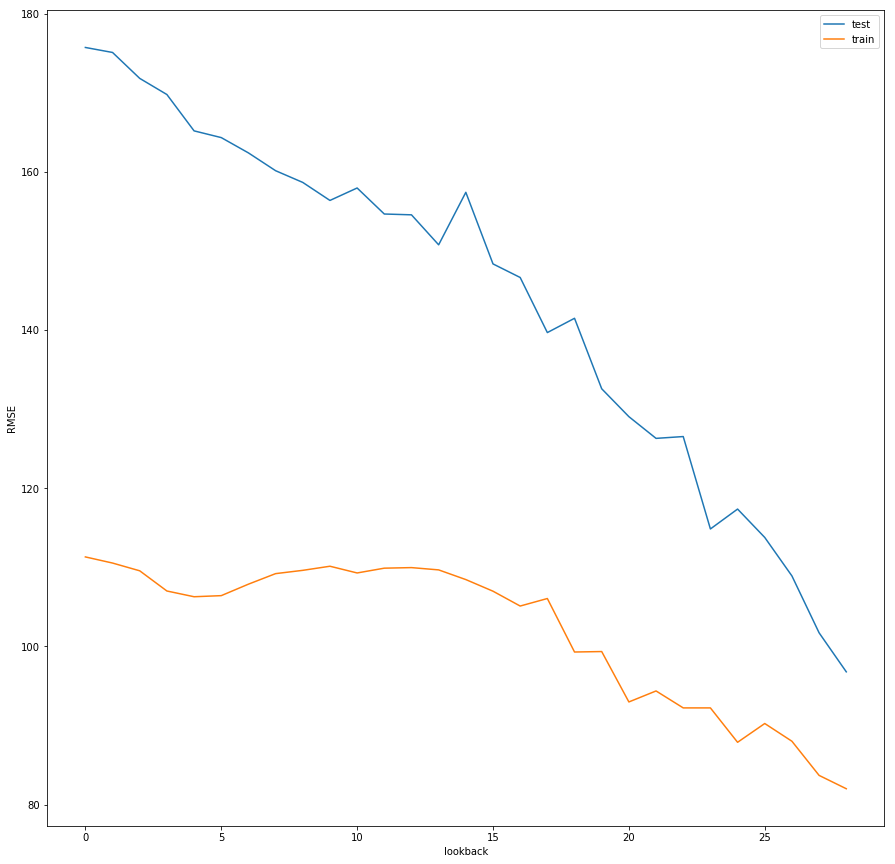

In [2]:
import matplotlib.pyplot as plt
plt.suptitle('scores', fontsize=20)
plt.figure(figsize=(15,15))
plt.plot(score['test_score'], label='test')
plt.plot(score['train_score'], label='train')
plt.xlabel('lookback')    
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.show()

For each day of our production round, until day 30, we predict the value of our body weight on day 35. The RMSE is high in the beginning and decreases as we approach day 30 with a RMSE of 86.33g 

In [10]:
for i, _score in enumerate(score['test_score'], start = 2): # we start as of day 2 because our prediction needs 1 day in the past
    print('day {} : RMSE Test Run {}'.format(i, _score))

day 2 : RMSE Test Run 175.7219548318453
day 3 : RMSE Test Run 175.0892654325197
day 4 : RMSE Test Run 171.8090611905568
day 5 : RMSE Test Run 169.77240856068707
day 6 : RMSE Test Run 165.176662208764
day 7 : RMSE Test Run 164.32894996253754
day 8 : RMSE Test Run 162.394729336271
day 9 : RMSE Test Run 160.39450198156806
day 10 : RMSE Test Run 158.66622005637856
day 11 : RMSE Test Run 153.68585284272913
day 12 : RMSE Test Run 153.23968669524575
day 13 : RMSE Test Run 153.71364697888862
day 14 : RMSE Test Run 149.79065939603558
day 15 : RMSE Test Run 147.32070074487993
day 16 : RMSE Test Run 145.65629623282356
day 17 : RMSE Test Run 143.08406413605334
day 18 : RMSE Test Run 138.82464924954874
day 19 : RMSE Test Run 136.2368986310354
day 20 : RMSE Test Run 130.26507636587746
day 21 : RMSE Test Run 129.58443862474414
day 22 : RMSE Test Run 126.64575842898472
day 23 : RMSE Test Run 122.19134273911278
day 24 : RMSE Test Run 120.5450458379521
day 25 : RMSE Test Run 119.2355274120406
day 26 : R